In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('our-bma.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCAAGGCAGTAGGGCCTACCAAATCGGGTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGAACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCTATTTTGT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGAAAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGGCCGTCCTATGCTGGAATAATGAAACGACAACCTGTCTTCG...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 47466.26it/s]


[74, 467, 777, 1098, 1398, 1644, 1799, 2042, 2249, 2433, 2540, 2740, 2747, 2923, 3039, 3144, 3266, 3258, 3316, 3464, 3526, 3570, 3595, 3674, 3721, 3759, 3799, 3786, 3874, 3891, 3937, 3992, 3987, 4012, 4065, 4107, 4145, 4066, 4159, 4186, 4183, 4157, 4172, 4183, 4185, 4230, 4210, 4240, 4220, 4170, 4268, 4215, 4252, 4255, 3965, 3979, 3956, 3991, 3970, 3948, 4047, 3974, 3915, 3983, 4021, 3963, 3961, 4012, 3942, 3895, 3902, 3974, 3870, 3879, 3833, 3827, 3817, 3792, 3800, 3700, 3664, 3647, 3569, 3621, 3554, 3444, 3383, 3397, 3350, 3228, 3187, 3148, 2999, 2941, 2885, 2758, 2660, 2518, 2416, 2221, 2070, 1931, 1834, 1563, 1364, 1150, 836, 532, 205, 15]


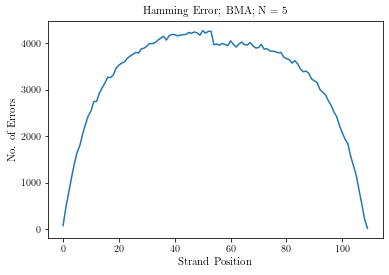

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 10', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov10-sab-bma-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:10<00:00, 949.83it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


TCA -> G 6
C -> GGA 6
 -> GCGG 6
CCG ->  6
GC -> T 6
 -> GGGT 6
 -> TTGG 6
T -> GAG 6
 -> CTA 6
 -> TGGT 6
TC -> GG 6
 -> CAAC 6
T -> CCA 6
CG -> T 6
AC -> GG 6
AT -> CC 6
A -> GGC 7
 -> CATT 7
T -> AAG 7
GGC ->  7
A -> CCG 7
GTT ->  7
 -> AAGG 7
 -> AAAA 7
 -> GGAA 7
TC -> GA 7
AAA ->  7
GAA ->  7
C -> AAG 7
 -> AGGG 7
 -> GGGC 7
CTGA ->  7
 -> CCCG 7
T -> CCG 7
AG -> T 7
AG -> C 7
TAA ->  7
ACA ->  8
G -> TA 8
TCGA ->  8
CAT -> G 8
T -> GGGG 8
GCTA ->  8
GA -> C 8
 -> GGCC 8
AAT ->  8
GGT ->  8
T -> CGG 8
T -> GGC 9
AT -> GG 9
ATT ->  9
CCT ->  9
ACC ->  9
 -> TAC 9
 -> AGT 9
TGG ->  9
A -> CCC 9
TTA ->  9
TT -> C 9
TA -> GG 9
G -> CA 9
GC -> A 9
CC -> G 9
G -> CCC 10
 -> GTA 10
GA -> T 10
 -> TAT 10
T -> CCC 10
T -> AAA 10
TGCA ->  10
TTG ->  10
AA -> G 10
 -> GAT 10
 -> ATG 11
G -> AC 11
TT -> A 11
CGC ->  11
 -> CAC 11
G -> AT 11
 -> CTG 12
C -> GGGG 12
AAG ->  12
CAA ->  12
GT -> A 12
GTG ->  12
TAT ->  12
G -> AAA 12
 -> TAG 12
GT -> C 12
CT -> GG 12
AC -> T 12
 -> ATT 12
CAC ->

G -> C @ 74 6
 -> T @ 81 6
C -> GG @ 20 6
CG ->  @ 54 6
C -> GG @ 102 6
A -> C @ 74 6
A -> C @ 76 6
 -> C @ 79 6
A -> C @ 89 6
 -> A @ 73 6
G -> A @ 26 6
C -> GG @ 12 6
TC ->  @ 105 6
 -> GAC @ 53 6
C -> A @ 77 6
C -> A @ 78 6
G -> T @ 91 6
A -> C @ 78 6
A -> T @ 11 6
A -> C @ 81 6
 -> TG @ 52 6
C -> A @ 109 6
A -> G @ 72 6
C -> T @ 80 6
G -> C @ 84 6
CT ->  @ 8 6
G -> A @ 106 6
C -> A @ 86 6
CT ->  @ 56 6
GT ->  @ 8 6
A -> GG @ 7 6
 -> AGG @ 54 6
G -> T @ 35 6
C -> A @ 47 6
 -> AC @ 56 6
A -> C @ 37 6
A -> C @ 38 6
 -> T @ 37 6
C -> A @ 44 6
 -> A @ 74 6
C -> G @ 68 6
G -> T @ 15 6
A -> C @ 43 6
C -> G @ 67 6
CT ->  @ 14 6
GT ->  @ 13 6
 -> T @ 34 6
 -> T @ 73 6
G -> C @ 85 6
G -> T @ 88 6
G -> T @ 87 6
 -> ACA @ 54 6
CT ->  @ 100 6
 -> T @ 32 6
G -> C @ 92 6
AC ->  @ 10 6
CT ->  @ 103 6
GT ->  @ 26 6
GT ->  @ 28 6
G -> C @ 97 6
C -> A @ 71 6
TG ->  @ 55 6
G -> A @ 12 6
 -> T @ 76 6
 -> T @ 74 6
CT ->  @ 91 6
C -> A @ 33 6
 -> GTG @ 55 6
C ->  @ 58 6
 -> A @ 32 6
TT ->  @ 56 6
A -> G 

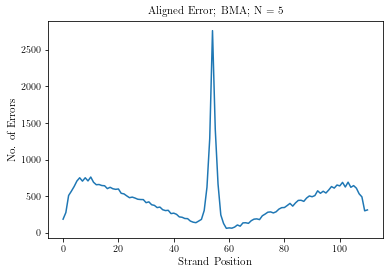

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 10', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov10-sab-bma-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 32, 50, 65, 88, 80, 67, 71, 94, 76, 70, 81, 65, 68, 63, 76, 62, 71, 59, 65, 67, 52, 62, 53, 49, 43, 57, 49, 44, 47, 46, 47, 31, 47, 36, 38, 39, 26, 34, 34, 25, 32, 26, 18, 22, 22, 9, 14, 13, 16, 9, 13, 19, 47, 127, 108, 48, 14, 2, 4, 4, 9, 8, 20, 10, 16, 15, 14, 18, 27, 18, 17, 17, 31, 29, 23, 22, 36, 37, 39, 41, 48, 42, 32, 58, 48, 64, 48, 46, 60, 54, 49, 77, 56, 57, 61, 49, 67, 64, 77, 90, 81, 67, 86, 68, 85, 64, 74, 57, 43, 42]
[0, 32, 47, 47, 50, 68, 72, 55, 79, 52, 56, 72, 51, 58, 48, 44, 50, 47, 40, 44, 52, 49, 42, 42, 30, 29, 54, 37, 36, 40, 28, 33, 28, 29, 23, 18, 24, 23, 21, 20, 20, 21, 18, 16, 17, 20, 13, 13, 7, 8, 7, 7, 16, 35, 118, 109, 34, 9, 6, 3, 7, 2, 5, 6, 10, 10, 10, 5, 12, 12, 13, 14, 23, 15, 22, 22, 19, 29, 31, 27, 19, 35, 34, 33, 28, 35, 39, 31, 41, 43, 34, 42, 38, 52, 45, 41, 58, 48, 48, 52, 64, 67, 56, 55, 55, 45, 46, 52, 52, 42, 35]
[0, 30, 53, 57, 54, 61, 62, 55, 43, 55, 66, 59, 61, 61, 46, 55, 59, 41, 55, 35, 52, 44, 39, 41, 45, 37, 34, 41, 25, 29, 25, 33,

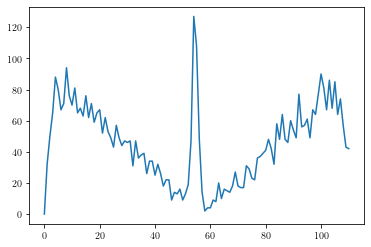

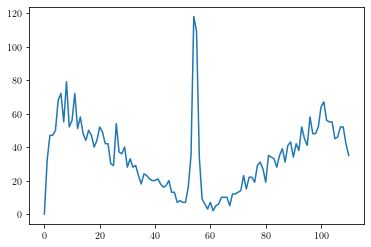

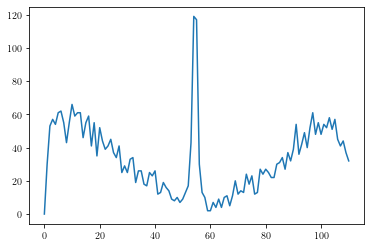

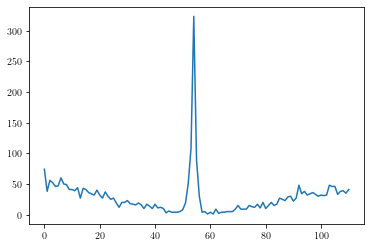

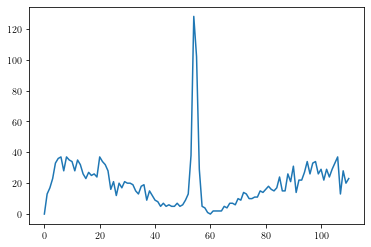

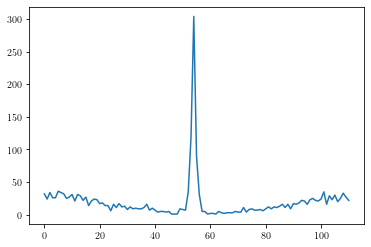

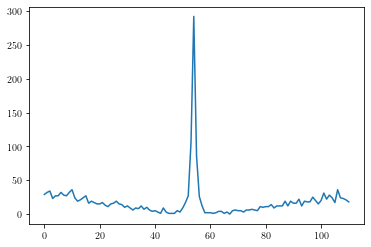

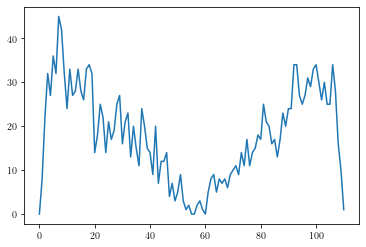

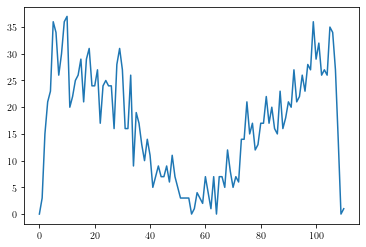

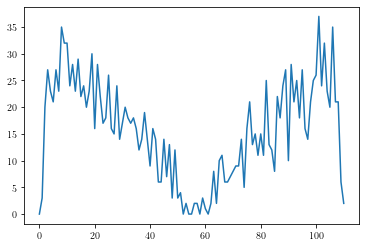

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)